In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import json
import h5py

sys.path.append(r"D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src")

import windIO
import wind
import windWT as wt
import windCAD
# import windOF as foam
import windCodes

import winsound

from matplotlib.ticker import FuncFormatter

In [63]:
# # Reset to the default font settings
# plt.rcdefaults()

# # turn on latex rendering for matplotlib with Times New Roman font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')



## Basic definitions

In [87]:
main_dir = r"D:/OneDrive - The University of Western Ontario\Documents/PhD/Thesis/BLWT_tests/2023_12_07_FFS_HFPI/Data/"

dir_wtCp_FFS = main_dir + r"HFPI_rawData/TNG-E1/run2/"
# dir_wtCp_FFS = main_dir + r"HFPI_rawData/TNG-E5/run2/"
# dir_wtCp_FFS = main_dir + r"HFPI_rawData/TNG-E4/run2/"

output_dir = main_dir + r"processedData/"

saveFigs = False
figDir = output_dir+ r"__plots/"
if saveFigs and not os.path.exists(figDir):
    os.makedirs(figDir)

In [65]:
B = 3.4
D = 2.43
lScl=1/50.0

Hr = 0.08  # ridge height
roofSlope = 0  # roof slope
He = Hr - D/2.0*np.sin(np.deg2rad(roofSlope))  # eaves height
Havg = np.mean([Hr, He])
H = Havg  # average roof height
print("Hr = {:.5g} m, He = {:.5g} m, Havg = {:.5g} m".format(Hr, He, Havg))

areaFactor_toFSm2 = (1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale

fluidDensity = 1.225  # only for wind tunnel
fluidKinematicViscosity = 1.48e-5

badTaps = None


Hr = 0.08 m, He = 0.08 m, Havg = 0.08 m


## Building Geometry

In [66]:
tapFile = main_dir + r"ffsTapDefinition.csv"
tapInfo = pd.read_csv(tapFile)

faceID = [1,2]
name = ['Front','Top']
note = ['','']
origin = [[0,0,0],
          [0,0,0.08],]
basisVectors = [[[0,-1,0],[0,0,1],[-1,0,0]],
                [[0,-1,0],[1,0,0],[0,0,1]],]

origin_plt = [[0, 0],
              [0, 0],]

basisVectors_plt = [[[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    ]
vertices = [[[-0.01,0],[-0.01,0.08],[0.01,0.08],[0.01,0],[-0.01,0]],
            [[-0.01,0],[-0.01,0.45],[0.01,0.45],[0.01,0],[-0.01,0]],
            ]

lineDfn_AB = {
    'A': {'faceID':1, 'start': [0, 0], 'end': [0, 0.08], },
    'B': {'faceID':2, 'start': [0, 0], 'end': [0, 0.45], },
    }


In [67]:

faces_FFS = []
for i,f in enumerate(faceID):
    idx = tapInfo.index[tapInfo.faceID == f]
    tapCoords = np.transpose(np.array([tapInfo.x[idx], tapInfo.y[idx]]))
    tapNos = np.array(tapInfo.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                )
    # fc.plot(figSize=[20,15], overlayPanels=True, overlayTaps=True, overlayTribs=True, overlayZones=True)
    faces_FFS.append(fc)
# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

Generating panels ...
Generating panels ...


In [68]:
FFS = wind.bldgCp(bldgName='FFS',
                faces=faces_FFS,
                H=H, He=He, Hr=Hr,
                D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='GeomDefinition',
                AoA_zero_deg_basisVector=[1,0],
                AoA_rotation_direction='CCW',
                )
print(json.dumps(FFS.panelingErrors, indent=4, separators=(',', ':')))

Refreshing GeomDefinition...
Verifying data ...
Done refreshing GeomDefinition.

{
    "Face 1":null,
    "Face 2":null
}


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:773: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:3166: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.00836 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-85 ($z_0=0.00099 m$). Skipping velocity statistics calculation.
Fitted z0 = 0.0084m @FS
0.00016784668167071532


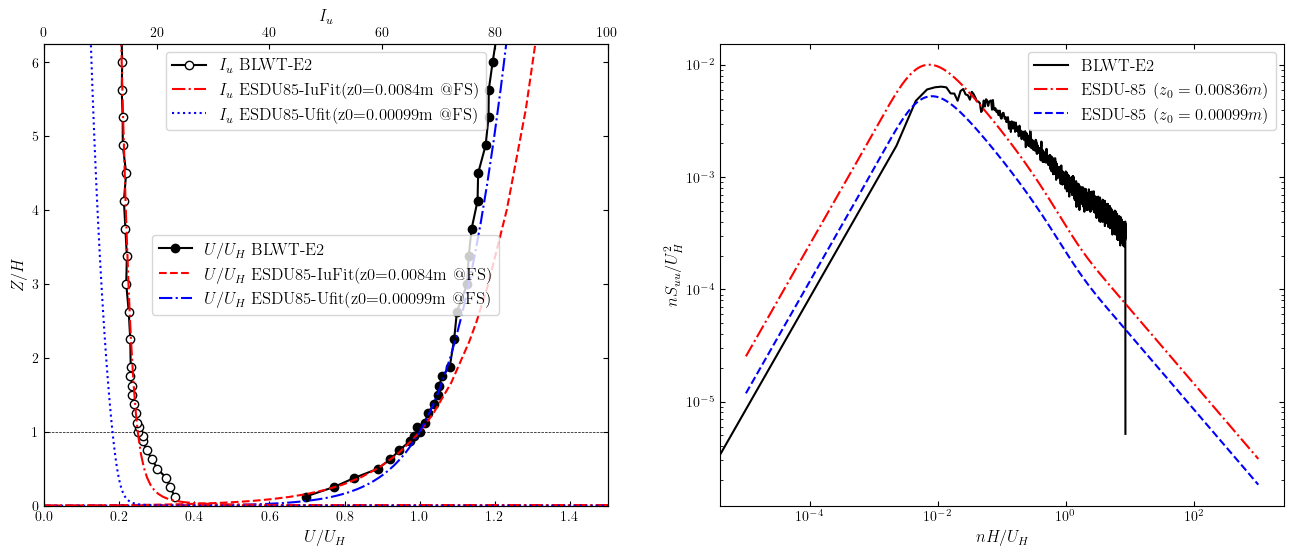

In [69]:
keepTH = False

temp = h5py.File(r"D:/tempData_depot/simData_CandC/wt_tngE2/"+r"tngE2Fr1_forPython.mat", 'r')
wtVel_E5 = wind.profile(name="BLWT-E2", Z=temp['Z'][0][()],UofT=temp['UofT'][()],VofT=temp['VofT'][()],WofT=temp['WofT'][()],H=H,dt=temp['dt'][0][0],nSpectAvg=64, 
                        workSect_zLim=[0, 0.5], lScl=lScl,
                        keepTH=keepTH)
wtVel_E5.kwargs_z0_fit = {'fitTo':'Iu', # 'Iu' or 'U'
                        'uStar_init':1.0, 
                        'z0_init':0.001, 
                        'kwargs_z0Fit':{'z0i':[1e-10,1.0]}}
wtVel_E5.fit_z0(debugMode=True, )
print(wtVel_E5.z0_Iu)


## Surface pressure, $C_p$

In [70]:
peakSpecs = wind.DEFAULT_PEAK_SPECS
peakSpecs['Num_seg'] = 16
peakSpecs['Duration'] = 16
peakSpecs['prob_non_excd'] = 0.8

### Wind tunnel data

In [71]:
analogChannels_idxs={
                'main_pitot': 0,
                'xref_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 509,
                'main_pitot_q': 510,
                '20inch_pitot_zero': 507,
                '20inch_pitot_q': 508,
                'Uh_pitot_zero': 505,
                'Uh_pitot_q': 506,
            }

mainRefPitotChnlIdx = 2
Zpitot = 1.48
Ntaps = 57
lowpassFreq=200.0

In [72]:
print(dir_wtCp_FFS)

D:/OneDrive - The University of Western Ontario\Documents/PhD/Thesis/BLWT_tests/2023_12_07_FFS_HFPI/Data/HFPI_rawData/TNG-E5/run2/


In [88]:
# cps_OP = []
# i, rID = 0, runIDs[0]
# for i, rID in enumerate(runIDs):
# print(">> Processing: OP-"+rID)
cp_raw = wt.BLWTL_HFPI(
    caseDir=dir_wtCp_FFS,
    userNotes=None,
    Z_MainPitot=Zpitot,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    # lowpassFreq=lowpassFreq,
    Ntaps=Ntaps,
    # AoAsToRead=None,
)
winsound.Beep(1000, 1000)
print("      Loaded raw data")
print(cp_raw.description)


Reading HFPI data from: D:/OneDrive - The University of Western Ontario\Documents/PhD/Thesis/BLWT_tests/2023_12_07_FFS_HFPI/Data/HFPI_rawData/TNG-E1/run2/
   Reading file: D:/OneDrive - The University of Western Ontario\Documents/PhD/Thesis/BLWT_tests/2023_12_07_FFS_HFPI/Data/HFPI_rawData/TNG-E1/run2/TNGr2E01R001P001a.pssd
   Reading file: D:/OneDrive - The University of Western Ontario\Documents/PhD/Thesis/BLWT_tests/2023_12_07_FFS_HFPI/Data/HFPI_rawData/TNG-E1/run2/TNGr2E01R002P001a.pssd
   Reading file: D:/OneDrive - The University of Western Ontario\Documents/PhD/Thesis/BLWT_tests/2023_12_07_FFS_HFPI/Data/HFPI_rawData/TNG-E1/run2/TNGr2E01R003P001a.pssd
   Reading file: D:/OneDrive - The University of Western Ontario\Documents/PhD/Thesis/BLWT_tests/2023_12_07_FFS_HFPI/Data/HFPI_rawData/TNG-E1/run2/TNGr2E01R004P001a.pssd
   Reading file: D:/OneDrive - The University of Western Ontario\Documents/PhD/Thesis/BLWT_tests/2023_12_07_FFS_HFPI/Data/HFPI_rawData/TNG-E1/run2/TNGr2E01R005P001a.

In [89]:
# print([f"[{a}, {b}]" for a, b in zip(cp_raw.tapNos, bldg.tapNo)])
print(cp_raw.tapNos)


[101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 401, 402, 403, 404, 405, 406, 407, 408, 409]


In [90]:
print(cp_raw.CpTH.shape)

FFS_cp = wind.bldgCp(
                bldgName=FFS.name + 'BLWT',
                faces=FFS.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=FFS.AoA_zero_deg_basisVector,
                AoA_rotation_direction=FFS.AoA_rotation_direction,
                caseName='---',
                refProfile=wtVel_E5,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                Uref_FS=25.0,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                notes_Cp=cp_raw.description,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                CpStats_fields=['mean','std','peak','skewness','kurtosis'],
                keepTH=True,
                )
# FFS_cp.RemoveBadTaps(badTaps=badTaps, onlyFromData=True, )
# FFS_cp.name = 'BLWT'
print(f"Shape of CpTH: {FFS_cp.CpOfT.shape}")
winsound.Beep(1500, 1000)
print("      << Complete!")

FFS_cp.profile.fit_z0(debugMode=False,)
# cps_OP.append(cp)

# FFS_cp.sampleLines = allLines.copy()
# for key in FFS_cp.sampleLines.keys():
#     FFS_cp.sampleLines[key].parentBldg = FFS_cp

# del cp_raw, cp

(7, 57, 120000)
Re-scaling profile to match Uref ...
    Uref_avg = 9.117 m/s
    U_ref_prof = 7.604 m/s
    U_ratio = 1.199
    time_ratio = 0.834
Refreshing ---...
Verifying data ...
Computing Cp statistics ...
Done refreshing ---.

Shape of CpTH: (7, 57, 120000)
      << Complete!
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Fitted z0 = 0.0084m @FS


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:773: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)


0.00016784668167071532

In [91]:
allLines = {}
lines = []
for lineName in lineDfn_AB.keys():
    faceID = lineDfn_AB[lineName]['faceID']
    fIdx = faceID-1
    line = windCAD.samplingLine(
        name=lineName,
        parentFace=FFS.faces[fIdx],
        start_xy=lineDfn_AB[lineName]['start'],
        end_xy=lineDfn_AB[lineName]['end'],
        fringeDistance=0.003,
        )
    lines.append(line)
linesAB_WT = wind.SampleLinesCp(lines=lines, parentBldg=FFS, name='AB')
allLines['AB'] = wind.SampleLinesCp(lines=lines, parentBldg=None, name='AB')
print(f"Taps of AB: {linesAB_WT.tapNo()}")
print(f"No. of taps in AB: {len(linesAB_WT.tapNo())}")

Taps of AB: [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 401, 402, 403, 404, 405, 406, 407, 408, 409]
No. of taps in AB: 57


In [92]:
print(FFS_cp.AoA)
FFS_cp.AoA = [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0,]
print(FFS_cp.AoA)

[0. 0. 0. 0. 0. 0. 0.]
[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0]


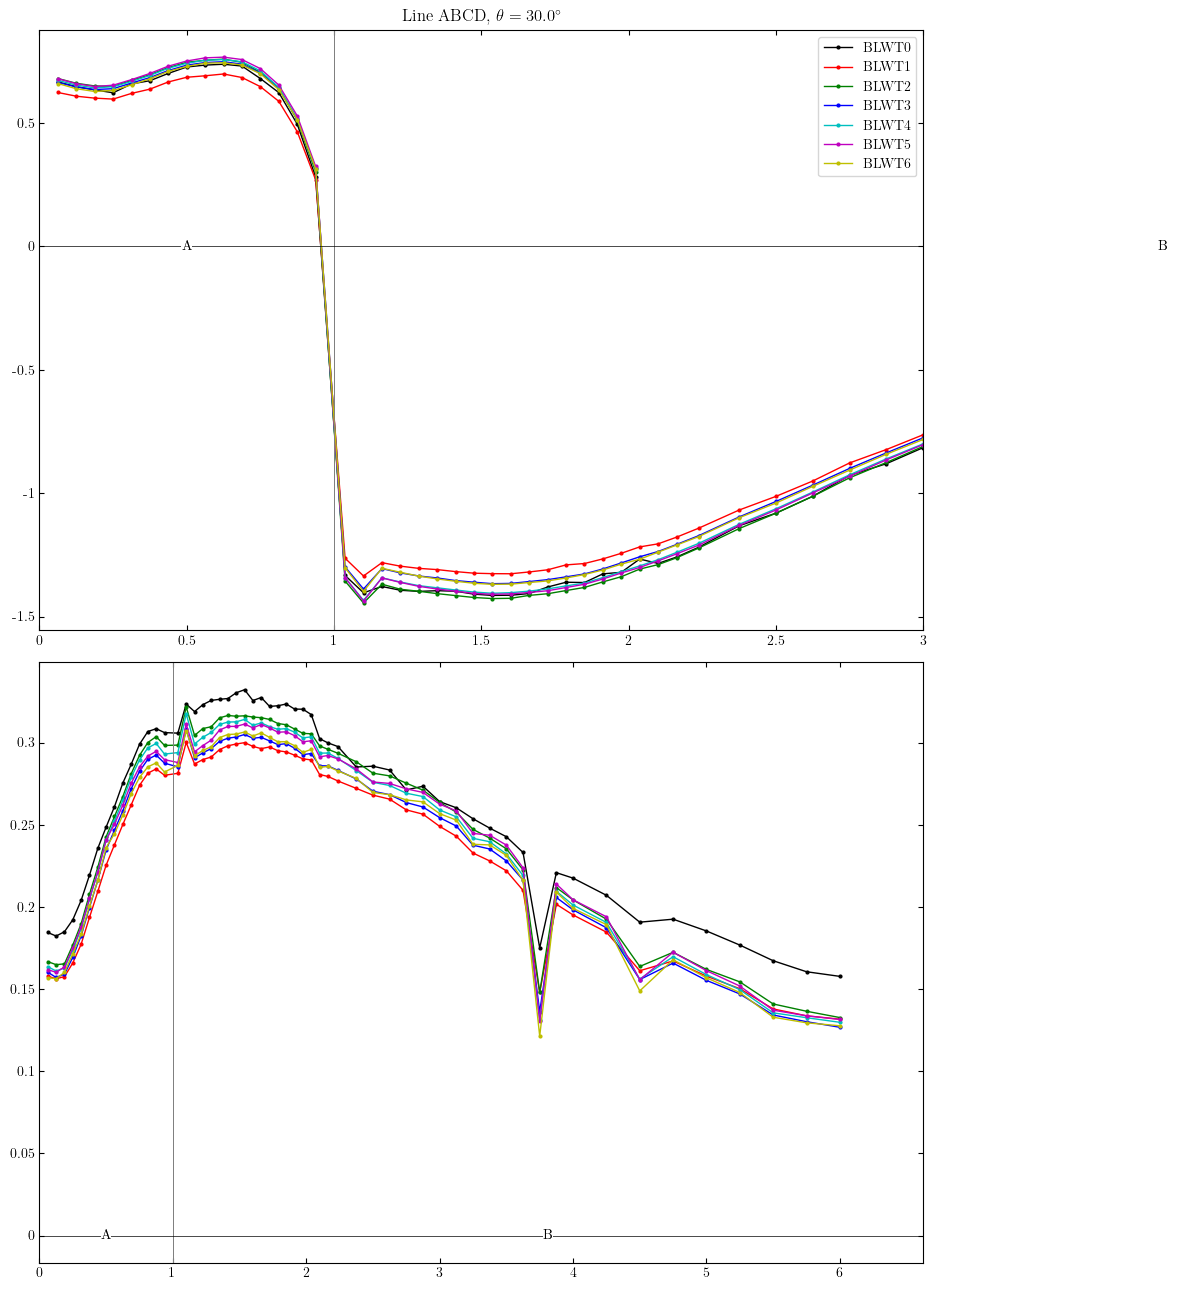

In [93]:
showLES_corr = True
showLES_uncorr = True
ms = 2
lw = 1.0
kwargs_plt={'ls':'-', 'marker':'o', 'color':'k', 'ms':ms, 'lw':lw}

fig, axs = plt.subplots(2, 1, figsize=[12,13.0],)

colors = ['k', 'r', 'g', 'b', 'c', 'm', 'y',]

ax = axs[0]
label = "BLWT"
linesAB_WT.parentBldg = FFS_cp
for i, AoA in enumerate(FFS_cp.AoA):
    kwargs_plt['color'] = colors[i]
    linesAB_WT.plotCpStats(ax=ax, AoA=AoA, field='mean', showXLabel=False, showYLabel=False, label=label+str(i), kwargs_plt=kwargs_plt)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.legend(loc='upper right')
ax.set_xlim([0, 3.0])#linesAB_WT.length_Norm])
ax.set_title(f"Line ABCD, $\\theta={AoA}^\circ$")
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)


ax = axs[1]
label = "BLWT"
for i, AoA in enumerate(FFS_cp.AoA):
    kwargs_plt['color'] = colors[i]
    linesAB_WT.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesAB_WT.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)

# ax = axs[2]
# label = "BLWT"
# linesAB_WT.parentBldg = FFS_cp
# linesAB_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMax', showXLabel=False, showYLabel=False, label='', kwargs_plt=kwargs_plt_WTavg)
# linesAB_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMin', showXLabel=False, showYLabel=False, label=label, showLineSegmentNames=False, kwargs_plt=kwargs_plt_WTavg)
# ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
# ax.set_xlim([0, linesAB_WT.length_Norm])
# wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)

# ax = axs[3]
# label = "BLWT"
# linesAB_WT.parentBldg = FFS_cp
# linesAB_WT.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
# ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
# ax.set_xlim([0, linesAB_WT.length_Norm])
# wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)


# ax = axs[4]
# label = "BLWT"
# linesAB_WT.parentBldg = FFS_cp
# linesAB_WT.plotCpStats(ax=ax, AoA=AoA, field='kurtosis', showXLabel=True, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
# ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
# ax.set_xlim([0, linesAB_WT.length_Norm])
# wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)



plt.tight_layout()

plt.show()



Message from Profiles.plotProfile_basic2(): Future feature notice: a table of normalizers like H, Uref, etc. next to the legend.
          Location: D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py
          Function: plotProfile_basic2
          Line number: 5186


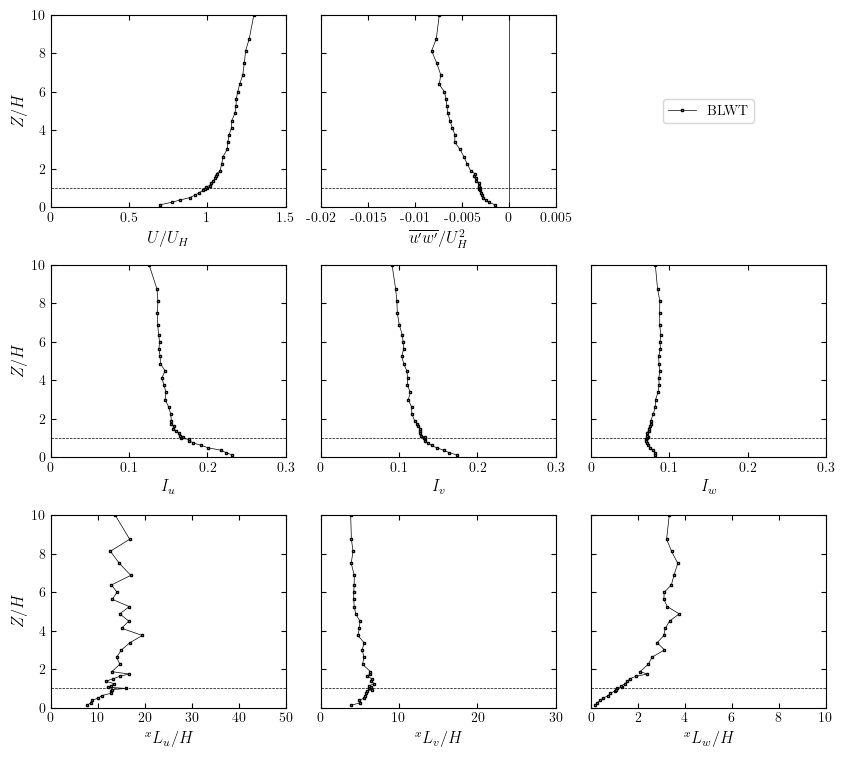

In [94]:
FFS_cp.profile.name = 'BLWT'

# profs = wind.Profiles([es74, es85, WT_cp.profile, LES_Cp.profile]) #, es74, es85])
profs = wind.Profiles([FFS_cp.profile]) #, es74, es85])

fig, axs = profs.plotProfile_basic2(figsize=[10,9], hspace=0.3, wspace=0.15, sharey=True,
            yLimits=[0,10], showSubPlotLabels=False, #subPlotLabels={'U':'(a)', 'uw':'(b)', 'Iu':'(c)', 'Iv':'(d)', 'Iw':'(e)', 'xLu':'(f)', 'xLv':'(g)', 'xLw':'(h)'},
            xLimits_U=[0, 1.5], xLimits_uw=[-0.02, 0.005], 
            xLimits_Iu=[0,0.3], xLimits_Iv=[0,0.3], xLimits_Iw=[0,0.3], 
            xLimits_xLu=[0, 50], xLimits_xLv=[0,30], xLimits_xLw=[0,10], 
            kwargs_plt=[
                        # {'color': 'b', 'linewidth':1.0, 'linestyle': '-',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        # {'color': 'g', 'linewidth':1.0, 'linestyle': '--',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'k', 'linewidth':0.5, 'linestyle': '-',       'marker': 's', 'markersize':2, 'markerfacecolor':'w'},
                        {'color': 'r', 'linewidth':1.0, 'linestyle': '-',       'marker': 'None', 'markersize':3, 'markerfacecolor':'w'},
                        {'color': 'k', 'linewidth':1.0, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        ],
            lgnd_kwargs={'bbox_to_anchor': (0.5, 0.5), 'loc': 'center', 'ncol': 1},
            kwargs_ax={'gridMajor':False}
            )
# # if saveFigs:
# fig.savefig(figDir+"profile_basic2_simple_4ppt_wtLES.svg",format='svg',dpi=1200, bbox_inches='tight')
# #     fig.savefig(figDir+"profile_basic2_simple.pdf",format='pdf',dpi=1200, bbox_inches='tight')
#     print(f"Figure saved to {figDir}profile_basic2.svg")


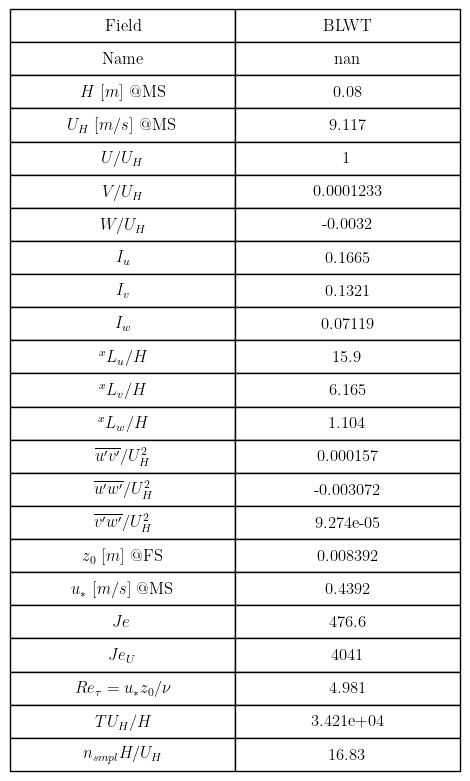

In [95]:
fig, _ = profs.plotParamsTable( colTxtColors=['k','r','b','g'], fontSz=12, 
                                params = 'all',
                                # params = wind.mathName(['H','Iu','Iv','Iw']),
                                )
# if saveFigs:
#     fig.savefig(figDir+"paramsTable_vel.svg",format='svg',dpi=1200, bbox_inches='tight')

In [96]:
vonk = wind.profile(name='vonKarman', )
Sp = wtVel_E5.SpectH.copy()
n = np.logspace(-3, 3, 100)
Suu, Svv, Sww = wind.vonKarmanSpectra(n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)
vonk.SpectH = wind.spectra(name=vonk.name, Z=H, Suu=Suu, Svv=Svv, Sww=Sww, n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)

# es74.SpectH.name = 'ESDU'
# profss = wind.Profiles([WT_cp.profile, LES_Cp.profile, es74, es85, vonk]) #, es85])
profss = wind.Profiles([FFS_cp.profile, LES_Cp.profile, ]) #, es85])
LES_Cp.profile.SpectH.name = 'LES'
FFS_cp.profile.SpectH.name = 'BLWT'

clb = 0
r = [1.0, clb, clb, 1.0]
b = [clb, clb, clb, 1.0]
kwargs_plt=[{'color': b, 'markerfacecolor':b, 'markeredgecolor':b, 'alpha':1, 'linewidth':0.5, 'linestyle': '-',    'marker': '+', 'markersize':1},
                            {'color': r, 'markerfacecolor':r, 'markeredgecolor':r, 'alpha':1, 'linewidth':1, 'linestyle': '-',    'marker': '', 'markersize':2},
                            {'color': 'g', 'linewidth':2, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                            {'color': 'b', 'linewidth':2, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                            {'color': 'm', 'linewidth':2, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                            ]

fig, _ = profss.plotSpectra(figsize=[12,3.5], #figsize=[12,2.5], #
                        normalize=True,
                        xLimits=[1e-3, 10], 
                        yLimits=[[1e-4,2e-2],[1e-4,2e-2],[1e-4,2e-2]], 
                        # yLimits=[[5e-4,2e-2],[5e-4,2e-2],[5e-4,2e-2]], 
                        wspace=0.15, shareY=True, normU='U', normZ='Z',
                        showSubPlotLabels=False,
                        subPlotLabel_xy=[0.9,0.9],
                        kwargs_plt=kwargs_plt,
                        kwargs_ax={'gridMajor':False, 'gridMinor':False},
                        )
# fig.tight_layout()
# reduce the gap between subplots
# fig.subplots_adjust(wspace=0.37)

if saveFigs:
    fig.savefig(figDir+'spectra_4ppt_wtLES.svg', format='svg',dpi=600, bbox_inches='tight')
    # fig.savefig(figDir+'spectra.svg', format='svg',dpi=600, bbox_inches='tight')
    # fig.savefig(figDir+'spectra.pdf', format='pdf',dpi=600, bbox_inches='tight')
    print(f"Figure saved: {figDir}/spectra.svg")
# fig.savefig(figDir+'spectra_clipped.svg', format='svg',dpi=600, bbox_inches='tight')

No velocity time history found for vonKarman. Skipping velocity statistics calculation.


NameError: name 'LES_Cp' is not defined